# Import Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

import time
from datetime import datetime, timedelta

# Load Datasets

In [5]:
data = pd.read_fwf('drive/My Drive/RandomProjects/OZONE/dobson_toARH.txt')
data.head()

,Local_Date,Time,DOY,UTC_Date,Time.1,DOY.1,Total_Ozone,Mu,INS,LS,Wavelength,Kind_of_Obs.
0,1988/01/19,13:53,19,1988/01/19,01:53,19,298.0,1.854,17,0,AD,Direct_Sun
1,1988/01/20,13:25,20,1988/01/20,01:25,20,280.0,1.852,17,0,AD,Direct_Sun
2,1988/01/21,11:38,21,1988/01/20,23:38,20,279.0,1.907,17,0,AD,Direct_Sun
3,1988/01/22,13:24,22,1988/01/22,01:24,22,300.0,1.873,17,3,AD,Zenith_Cloud
4,1988/01/23,10:19,23,1988/01/22,22:19,22,285.0,2.072,17,0,AD,Direct_Sun


In [6]:
data = data[['Local_Date', 'Total_Ozone']]
data.head()

,Local_Date,Total_Ozone
0,1988/01/19,298.0
1,1988/01/20,280.0
2,1988/01/21,279.0
3,1988/01/22,300.0
4,1988/01/23,285.0


In [10]:
data.Local_Date = pd.to_datetime(data.Local_Date)
data = data.set_index('Local_Date')
data.head()

,Total_Ozone
Local_Date,
1988-01-19,298.0
1988-01-20,280.0
1988-01-21,279.0
1988-01-22,300.0
1988-01-23,285.0


In [89]:
data.tail()

,Total_Ozone
Local_Date,
2018-10-31,209.0
2018-11-01,248.0
2018-11-02,211.0
2018-11-03,185.0
2018-11-05,286.0


# Data Preprocessing

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    print(len(dataset))
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
        
    return np.array(dataX), np.array(dataY)

## Split data into Train and Test sets

In [71]:
# Split the series for training and testing
size = data.shape[0]
tr =int(round(size*0.8))
X_train, X_test = data[:tr] , data[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create train and test windows
look_back = 7
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



3027
757


# Create a time-series data for input to the LSTM Netwrok

In [0]:
n_input = 7
n_features = 1

generator = TimeseriesGenerator(train, train, length= n_input)

# Create an LSTM Model

In [79]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(100, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
training = model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               43200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3019/3019 [==============================] - 15s 5ms/step - loss: 2823.9175
Epoch 2/10
3019/3019 [==============================] - 14s 5ms/step - loss: 1418.2596
Epoch 3/10
3019/3019 [==============================] - 14s 5ms/step - loss: 1391.2647
Epoch 4/10
3019/3019 [==============================] - 14s 5ms/step - loss: 1258.5983
Epoch 5/10
3019/3019 [==============================] - 14s 5ms/step - loss: 1206.3960
Epoch 6/10
3019/3019 [==============================] - 14s 5ms/step - loss:

In [0]:

# # create and fit the LSTM network
# model = Sequential()

# model.add(LSTM(200, input_shape=(1, n_input), activation='relu', dropout=0.2))

# model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
# model.summary()

# opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

# model.compile(loss='mean_squared_error', optimizer=opt)

# start = time.time()
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
# end = time.time()

# runtime = end-start
# print('Runtime: ', runtime, 'seconds')

# Plot Training Loss vs Epochs

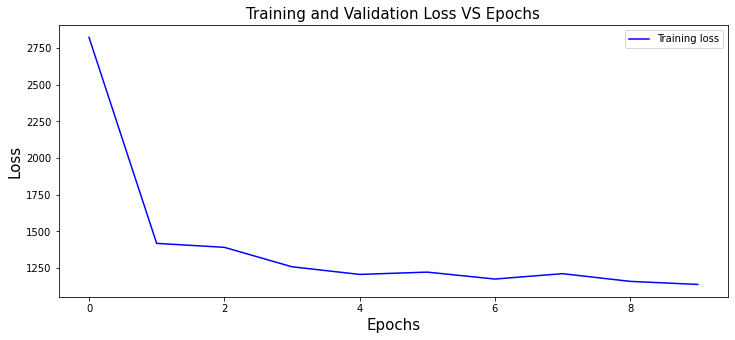

In [80]:
loss = training.history["loss"]

epochs = range(len(loss))

plt.figure(figsize=(12, 5))
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.title('Training and Validation Loss VS Epochs', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

# Generate Predictions

In [0]:
dates_range = 15
new_data = data.copy()

length = data.shape[0]
new_data = new_data.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(data.index[-1], periods= dates_range)

for i in range(dates_range-1):
    col = new_data['Total_Ozone']
    value = col[-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Predictions'] )
    new_data = new_data.append(df, ignore_index=True)

new_data = new_data.set_index('index')

In [88]:
new_data

,Local_Date,Total_Ozone,Confirmed
index,,,
NaT,1988-01-19,298.0,NaN
NaT,1988-01-20,280.0,NaN
NaT,1988-01-21,279.0,NaN
NaT,1988-01-22,300.0,NaN
NaT,1988-01-23,285.0,NaN
...,...,...,...
2018-11-15,NaT,NaN,NaN
2018-11-16,NaT,NaN,NaN
2018-11-17,NaT,NaN,NaN


In [0]:
batch = np.append(batch[:, 1:, :], [[[2]]]],axis=1)
batch

In [82]:
preds = []
batch = train[-(n_input):].reshape((n_input, 1))

for i in range(n_input*20):
    preds.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[preds[i]]],axis=1)

df_preds = pd.DataFrame(scaled.inverse_transform(preds), index = data[-(20*n_input):].index, columns = ['Predictions'] )


ValueError: ignored

In [69]:
df_preds

,Predictions
Local_Date,
2016-10-30,167.591293
2016-10-31,171.894083
2016-11-01,176.700515
2016-11-02,181.521673
2016-11-03,186.937499
...,...
2018-10-31,297.169429
2018-11-01,297.170256
2018-11-02,297.171042


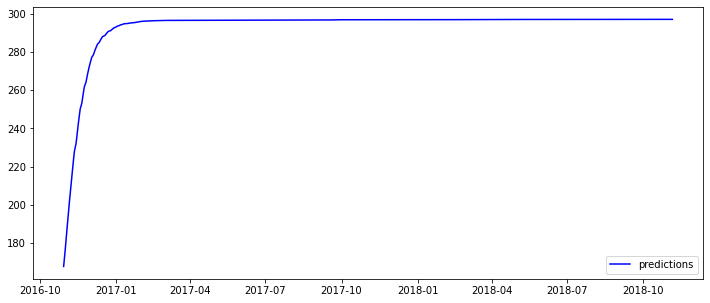

In [68]:
plt.figure(figsize=(12, 5))
plt.plot(df_preds.index, df_preds.Predictions, 'b-', label='predictions')
# plt.title('Training and Validation Loss VS Epochs', fontsize=15)
# plt.xlabel('Epochs', fontsize=15)
# plt.ylabel('Loss', fontsize=15)
plt.legend()

In [0]:
x_input = np.array([28,29,30]).reshape((1, n_input))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[32.07216]]


In [0]:
x_input = np.array([9, 10,11]).reshape((1, n_input))
x_input

array([[ 9, 10, 11]])

In [0]:
import numpy as np

a = np.zeros((2,2))
a

array([[0., 0.],
       [0., 0.]])

In [0]:
a[1,1] = 2
a

array([[0., 0.],
       [0., 2.]])

In [0]:
b = np.linspace(0,10,21)
b

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])